# Pain Meds

The author has long been interested in finding objective biomarkers of pain from biochemical data.  Finding such biomarkers could go a long way in improving pain management:
* matching the pain med strength to the objective severity of pain
* markers of disease improvement / progression in chronic pain conditions
* surrogate biomarkers for clinical trials
* forensic determination of licit and illicit drug use

Here, we are using NHANES data to look for correlations between the use of opiate and non-opiate pain medicine and clinical biochemistry.  Such correlations could help shed light on which patients are most likely to progress to long-term opiate use, and what are the biochemical effects of doing so.  We do not attempt to determine causality.  

Datasets to consider:

* DEMO: Demographic Variables
* RXQ_RX: Prescription Medications
* PAQ: Physical Activity
* SLQ: Sleep Disorders
* BIOPRO: Standard Biochemistry Profile
* BMX: Body Measures
* CBC: Complete Blood Count

From combined 2013–2018 data, we identified 5 groups of people (total N=13481):  
1) no prescription drug use (N=7122)  
2) non-CNS prescriptions only (N=4006)  
3) CNS, non-analgesics prescriptions (N=964)  
4) analgesics, non-narcotic prescriptions (N=679)  
5) narcotic analgesic prescriptions (N=710)  

Based on the preliminary analysis below, we need to perform matching on age, gender, and BMI.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy.stats
import sys

from scipy import stats

pd.options.display.max_rows = 96
pd.options.display.max_columns = 96
pd.options.display.max_colwidth = 128
sns.set_context('notebook')

formatter = logging.Formatter(
    fmt='%(asctime)s.%(msecs)03d %(levelname)s [%(name)s] %(message)s',
    datefmt='%y%m%d@%H:%M:%S',
)

logger = logging.getLogger('pynhanes')
logger.setLevel(logging.DEBUG)
# f = logging.FileHandler('nhanes.log')
# f.setFormatter(formatter)
h = logging.StreamHandler(stream=sys.stdout)
h.setFormatter(formatter)

if not logger.hasHandlers():
    logger.addHandler(h)  # log to STDOUT or Jupyter
#     logger.addHandler(f)  # log to file

import pynhanes

210308@04:05:19.428 DEBUG [pynhanes] pynhanes package (re)loaded


## Analgesic Drugs
NHANES dataset `RXD_DRUG: Prescription Medications - Drug Information` provides Multum Lexicon 3-level nested category system that assigns a therapeutic classification to each drug.  We are interested in:
* `First Level Category Name == 'CENTRAL NERVOUS SYSTEM AGENTS' | RXDDCI1A == 57`
* `Second Level Category Name == 'ANALGESICS' | RXDDCI1B == 58`
* `Third Level Category Name == 'NARCOTIC ANALGESICS' | RXDDCI1C == 60`
* `Third Level Category Name == 'NARCOTIC ANALGESIC COMBINATIONS' | RXDDCI1C == 191`


In [3]:
drugs = pynhanes.data.load_drugs()
drugs_cns = drugs[drugs.RXDDCI1A == 57].copy()
drugs_analgesics = drugs[drugs.RXDDCI1B == 58].copy()
drugs_narcotics =  drugs[drugs.RXDDCI1C.isin([60, 191])].copy()
logger.info(f'found {len(drugs_cns)} CNS drugs; {len(drugs_analgesics)} analgesics; {len(drugs_narcotics)} narcotic analgesics')
drugs_narcotics.tail(4)

210308@04:05:20.528 INFO [pynhanes.data] read 1513 rows x 63 cols from https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/RXQ_DRUG.xpt
210308@04:05:20.536 INFO [pynhanes] found 240 CNS drugs; 95 analgesics; 34 narcotic analgesics


,RXDDRGID,RXDDRUG,RXDINGFL,RXDDCI1A,RXDDCI1B,RXDDCI1C,RXDDCI2A,RXDDCI2B,RXDDCI2C,RXDDCI3A,RXDDCI3B,RXDDCI3C,RXDDCI4A,RXDDCI4B,RXDDCI4C,RXDICI1A,RXDICI1B,RXDICI1C,RXDICI2A,RXDICI2B,RXDICI2C,RXDICI3A,RXDICI3B,RXDICI3C,RXDICI4A,RXDICI4B,RXDICI4C,RXDICI5A,RXDICI5B,RXDICI5C,RXDICI6A,RXDICI6B,RXDICI6C,RXDDCN1A,RXDDCN1B,RXDDCN1C,RXDDCN2A,RXDDCN2B,RXDDCN2C,RXDDCN3A,RXDDCN3B,RXDDCN3C,RXDDCN4A,RXDDCN4B,RXDDCN4C,RXDICN1A,RXDICN1B,RXDICN1C,RXDICN2A,RXDICN2B,RXDICN2C,RXDICN3A,RXDICN3B,RXDICN3C,RXDICN4A,RXDICN4B,RXDICN4C,RXDICN5A,RXDICN5B,RXDICN5C,RXDICN6A,RXDICN6B,RXDICN6C
1040,d04269,ACETAMINOPHEN; CAFFEINE; DIHYDROCODEINE,2.0,57.0,58.0,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,58.0,59.0,57.0,58.0,60.0,57.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESIC COMBINATIONS,,,,,,,,,,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,MISCELLANEOUS ANALGESICS,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESICS,CENTRAL NERVOUS SYSTEM AGENTS,CNS STIMULANTS,,,,,,,,,,
1172,d04766,ACETAMINOPHEN; TRAMADOL,2.0,57.0,58.0,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,58.0,59.0,57.0,58.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESIC COMBINATIONS,,,,,,,,,,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,MISCELLANEOUS ANALGESICS,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESICS,,,,,,,,,,,,
1201,d04819,BUPRENORPHINE; NALOXONE,2.0,57.0,58.0,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,58.0,60.0,105.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESIC COMBINATIONS,,,,,,,,,,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESICS,MISCELLANEOUS AGENTS,ANTIDOTES,,,,,,,,,,,,,
1373,d07453,TAPENTADOL,1.0,57.0,58.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,58.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESICS,,,,,,,,,,CENTRAL NERVOUS SYSTEM AGENTS,ANALGESICS,NARCOTIC ANALGESICS,,,,,,,,,,,,,,,


## Load main data (2013–2018)

Inclusion criteria:
* 18–65 yo
* has BIOPRO, BMX, and CBC data
* responsed "yes" or "no" to `RXQ_RX.RXDUSE`

In [4]:
dfs = pynhanes.data.load(datasets=['DEMO','RXQ_RX','BIOPRO','BMX','CBC'], years=(2013, 2018))

210308@04:05:21.909 INFO [pynhanes.data] read 10175 rows x 47 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.XPT
210308@04:05:23.039 INFO [pynhanes.data] read 9971 rows x 47 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.XPT
210308@04:05:23.973 INFO [pynhanes.data] read 9254 rows x 46 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT
210308@04:05:23.993 INFO [pynhanes.data] combined DEMO datasets: 29400 rows x 52 cols
210308@04:05:26.578 INFO [pynhanes.data] read 20194 rows x 13 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/RXQ_RX_H.XPT
210308@04:05:29.060 INFO [pynhanes.data] read 19647 rows x 13 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/RXQ_RX_I.XPT
210308@04:05:31.542 INFO [pynhanes.data] read 19643 rows x 13 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/RXQ_RX_J.XPT
210308@04:05:31.568 INFO [pynhanes.data] combined RXQ_RX datasets: 59484 rows x 14 cols
210308@04:05:32.191 INFO [pynhanes.data] read 6979 rows x 38 cols 

### Apply inclusion / exclusion criteria

In [5]:
incl1 = dfs['DEMO'].loc[dfs['DEMO'].RIDAGEYR.between(18,65), 'SEQN']
incl2_biopro = dfs['BIOPRO'].SEQN
incl2_bmx = dfs['BMX'].SEQN
incl2_cbc = dfs['CBC'].SEQN
incl3 = dfs['RXQ_RX'].loc[dfs['RXQ_RX'].RXDUSE.isin([1,2]), 'SEQN']
incl = set(incl1) & set(incl2_biopro) & set(incl2_bmx) & set(incl2_cbc)  & set(incl3)

logger.info(f'total participants included: {len(incl)}')

dfs['DEMO'] = dfs['DEMO'].loc[dfs['DEMO'].SEQN.isin(incl), :]
dfs['RXQ_RX'] = dfs['RXQ_RX'].loc[dfs['RXQ_RX'].SEQN.isin(incl), :]
dfs['BIOPRO'] = dfs['BIOPRO'].loc[dfs['BIOPRO'].SEQN.isin(incl), :]
dfs['BMX'] = dfs['BMX'].loc[dfs['BMX'].SEQN.isin(incl), :]
dfs['CBC'] = dfs['CBC'].loc[dfs['CBC'].SEQN.isin(incl), :]

210308@04:05:36.576 INFO [pynhanes] total participants included: 13481


### Identify Drug Status

In [6]:
on_any_drugs = dfs['RXQ_RX'].loc[dfs['RXQ_RX'].RXDUSE == 1, 'SEQN']
on_cns_drugs = dfs['RXQ_RX'].loc[dfs['RXQ_RX'].RXDDRGID.isin(drugs_cns.RXDDRGID), 'SEQN']
on_analgesics = dfs['RXQ_RX'].loc[dfs['RXQ_RX'].RXDDRGID.isin(drugs_analgesics.RXDDRGID), 'SEQN']
on_narcotics = dfs['RXQ_RX'].loc[dfs['RXQ_RX'].RXDDRGID.isin(drugs_narcotics.RXDDRGID), 'SEQN']

dfs['DEMO']['on_any_drugs'] = dfs['DEMO'].SEQN.isin(on_any_drugs)
dfs['DEMO']['on_cns_drugs'] = dfs['DEMO'].SEQN.isin(on_cns_drugs)
dfs['DEMO']['on_analgesics'] = dfs['DEMO'].SEQN.isin(on_analgesics)
dfs['DEMO']['on_narcotics'] = dfs['DEMO'].SEQN.isin(on_narcotics)

drug_status_columns = ['on_any_drugs','on_cns_drugs','on_analgesics','on_narcotics']
# turn 4 boolean values into a single column
dfs['DEMO']['drug_group'] = dfs['DEMO'][drug_status_columns].apply(sum, axis=1)
dfs['DEMO'].groupby(drug_status_columns + ['drug_group']).SEQN.nunique()

on_any_drugs  on_cns_drugs  on_analgesics  on_narcotics  drug_group
False         False         False          False         0             7122
True          False         False          False         1             4006
              True          False          False         2              964
                            True           False         3              679
                                           True          4              710
Name: SEQN, dtype: int64

In [7]:
drugs_by_gender = pd.concat([
    pd.crosstab(dfs['DEMO'].RIAGENDR.map({1:'M', 2: 'F'}), dfs['DEMO'].drug_group, margins=True, normalize='columns')*100,
    pd.crosstab(dfs['DEMO'].RIAGENDR.map({1:'M', 2: 'F'}), dfs['DEMO'].drug_group, margins=True),
]).round(0).astype(int)
drugs_by_gender.index = ['%(F)','%(M)','N(F)','N(M)','N(total)']
drugs_by_gender

drug_group,0,1,2,3,4,All
%(F),47,58,60,63,57,52
%(M),53,42,40,37,43,48
N(F),3317,2311,578,431,406,7043
N(M),3805,1695,386,248,304,6438
N(total),7122,4006,964,679,710,13481


## Between-group analysis

Age, gender, and BMI will confound everything

210308@04:05:36.938 INFO [pynhanes] Excluding drug_group 0: F=8.2, log p=-4.7


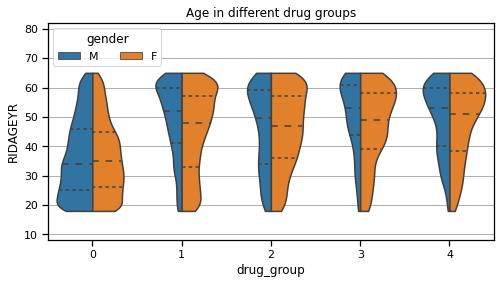

In [8]:
drugs_by_age = [g[1].RIDAGEYR.values for g in dfs['DEMO'].query('drug_group != 0').groupby('drug_group')]
anova = stats.f_oneway(*drugs_by_age)

logger.info(f'Excluding drug_group 0: F={anova[0]:.1f}, log p={np.log10(anova[1]):.1f}')

fig, ax = plt.subplots(figsize=(8,4))
ax.grid()
ax.set_axisbelow(True)
ax.set_ylim(8,82)
ax.set_title('Age in different drug groups')
ax.set_ylabel('Age (years)')
sns.violinplot(data=dfs['DEMO'], x='drug_group', y='RIDAGEYR', hue='RIAGENDR', cut=0, inner='quartiles', scale='count', split=True, ax=ax)

plt.legend(title='gender', handles=ax.get_legend().legendHandles, labels=('M','F'), ncol=2, loc='upper left')
plt.show()

In [9]:
biopro = pd.merge(
    left = dfs['DEMO'][['year','SEQN','drug_group','RIDAGEYR','RIAGENDR']],
    right = dfs['BIOPRO'],
    on = ['SEQN','year'],
    how = 'left',
)
logger.info(f'BIOPRO: {biopro.shape}')

bmx = pd.merge(
    left = dfs['DEMO'][['year','SEQN','drug_group','RIDAGEYR','RIAGENDR']],
    right = dfs['BMX'],
    on = ['SEQN','year'],
    how = 'left',
)
logger.info(f'BMX: {bmx.shape}')

cbc = pd.merge(
    left = dfs['DEMO'][['year','SEQN','drug_group','RIDAGEYR','RIAGENDR']],
    right = dfs['CBC'],
    on = ['SEQN','year'],
    how = 'left',
)
logger.info(f'CBC: {cbc.shape}')

210308@04:05:37.298 INFO [pynhanes] BIOPRO: (13481, 45)
210308@04:05:37.316 INFO [pynhanes] BMX: (13481, 32)
210308@04:05:37.334 INFO [pynhanes] CBC: (13481, 26)


### BIOPRO

In [10]:
kws = []
for col in [c for c in dfs['BIOPRO'].columns[1:] if 'X' in c]:
    biopro_by_age = [list(filter(lambda x: x==x, g[1][col].values)) for g in biopro.groupby('drug_group')]
    anova = stats.f_oneway(*biopro_by_age)
    kw = stats.kruskal(*biopro_by_age)
    kws.append(kw)
    logger.info(f'{col}: ANOVA F={anova[0]:.1f}, Kruskal–Wallis H={kw[0]:.1f}, KW log p={np.log10(kw[1]):.1f}')

210308@04:05:37.385 INFO [pynhanes] LBXSAL: ANOVA F=79.8, Kruskal–Wallis H=339.8, KW log p=-71.6
210308@04:05:37.404 INFO [pynhanes] LBXSAPSI: ANOVA F=22.1, Kruskal–Wallis H=98.5, KW log p=-19.7
210308@04:05:37.421 INFO [pynhanes] LBXSASSI: ANOVA F=1.9, Kruskal–Wallis H=9.1, KW log p=-1.2
210308@04:05:37.438 INFO [pynhanes] LBXSATSI: ANOVA F=0.3, Kruskal–Wallis H=11.5, KW log p=-1.7
210308@04:05:37.449 INFO [pynhanes] LBXSBU: ANOVA F=54.6, Kruskal–Wallis H=153.7, KW log p=-31.5
210308@04:05:37.461 INFO [pynhanes] LBXSC3SI: ANOVA F=2.6, Kruskal–Wallis H=7.5, KW log p=-0.9
210308@04:05:37.474 INFO [pynhanes] LBXSCA: ANOVA F=0.1, Kruskal–Wallis H=0.7, KW log p=-0.0
210308@04:05:37.484 INFO [pynhanes] LBXSCH: ANOVA F=4.6, Kruskal–Wallis H=21.6, KW log p=-3.6
210308@04:05:37.496 INFO [pynhanes] LBXSCK: ANOVA F=6.5, Kruskal–Wallis H=136.5, KW log p=-27.8
210308@04:05:37.506 INFO [pynhanes] LBXSCLSI: ANOVA F=25.1, Kruskal–Wallis H=82.8, KW log p=-16.4
210308@04:05:37.524 INFO [pynhanes] LBXSC

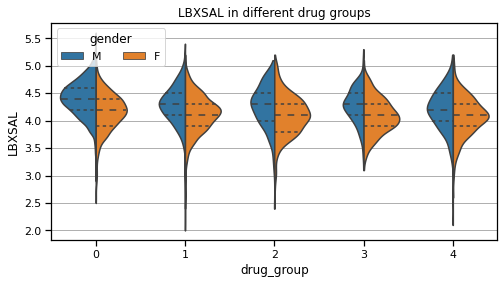

In [11]:
col = 'LBXSAL'

fig, ax = plt.subplots(figsize=(8,4))
ax.grid()
ax.set_axisbelow(True)
# ax.set_ylim(5,85)
ax.set_title(f'{col} in different drug groups')
ax.set_ylabel(col)
sns.violinplot(data=biopro, x='drug_group', y=col, hue='RIAGENDR', cut=0, inner='quartiles', scale='count', split=True, ax=ax)
plt.legend(title='gender', handles=ax.get_legend().legendHandles, labels=('M','F'), ncol=2, loc='upper left')
plt.show()

### BMX

In [12]:
kws = []
for col in [c for c in dfs['BMX'].columns[1:] if 'X' in c]:
    bmx_by_age = [list(filter(lambda x: x==x, g[1][col].values)) for g in bmx.groupby('drug_group')]
    anova = stats.f_oneway(*bmx_by_age)
    kw = stats.kruskal(*bmx_by_age)
    kws.append(kw)
    logger.info(f'{col}: ANOVA F={anova[0]:.1f}, Kruskal–Wallis H={kw[0]:.1f}, KW log p={np.log10(kw[1]):.1f}')

210308@04:05:38.149 INFO [pynhanes] BMXWT: ANOVA F=67.5, Kruskal–Wallis H=244.3, KW log p=-50.9
210308@04:05:38.163 INFO [pynhanes] BMXRECUM: ANOVA F=nan, Kruskal–Wallis H=nan, KW log p=nan
210308@04:05:38.168 INFO [pynhanes] BMXHEAD: ANOVA F=nan, Kruskal–Wallis H=nan, KW log p=nan
210308@04:05:38.181 INFO [pynhanes] BMXHT: ANOVA F=14.7, Kruskal–Wallis H=63.5, KW log p=-12.3
210308@04:05:38.193 INFO [pynhanes] BMXBMI: ANOVA F=113.2, Kruskal–Wallis H=414.9, KW log p=-87.8
210308@04:05:38.204 INFO [pynhanes] BMXLEG: ANOVA F=55.4, Kruskal–Wallis H=209.8, KW log p=-43.5
210308@04:05:38.215 INFO [pynhanes] BMXARML: ANOVA F=4.3, Kruskal–Wallis H=13.5, KW log p=-2.0
210308@04:05:38.226 INFO [pynhanes] BMXARMC: ANOVA F=44.5, Kruskal–Wallis H=165.8, KW log p=-34.1
210308@04:05:38.240 INFO [pynhanes] BMXWAIST: ANOVA F=160.4, Kruskal–Wallis H=615.3, KW log p=-131.1
210308@04:05:38.251 INFO [pynhanes] BMXSAD1: ANOVA F=120.4, Kruskal–Wallis H=429.1, KW log p=-90.8
210308@04:05:38.261 INFO [pynhanes

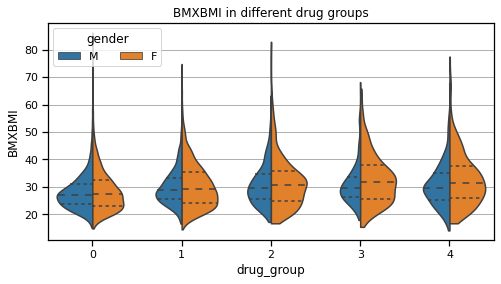

In [13]:
col = 'BMXBMI'

fig, ax = plt.subplots(figsize=(8,4))
ax.grid()
ax.set_axisbelow(True)
# ax.set_ylim(5,85)
ax.set_title(f'{col} in different drug groups')
ax.set_ylabel(col)
sns.violinplot(data=bmx, x='drug_group', y=col, hue='RIAGENDR', cut=0, inner='quartiles', scale='count', split=True, ax=ax)
plt.legend(title='gender', handles=ax.get_legend().legendHandles, labels=('M','F'), ncol=2, loc='upper left')
plt.show()

### CBC
The difference between drug groups is mainly due to gender differences.  Biggest F / H scores are observed for measures related to red blood cells (RBC count, hemoglobin, hematocrit).

In [14]:
kws = []
for col in dfs['CBC'].columns[1:]:
    cbc_by_age = [list(filter(lambda x: x==x, g[1][col].values)) for g in cbc.groupby('drug_group')]
    anova = stats.f_oneway(*cbc_by_age)
    kw = stats.kruskal(*cbc_by_age)
    kws.append(kw)
    logger.info(f'{col}: ANOVA F={anova[0]:.1f}, Kruskal–Wallis H={kw[0]:.1f}, KW log p={np.log10(kw[1]):.1f}')

210308@04:05:38.644 INFO [pynhanes] LBXWBCSI: ANOVA F=14.9, Kruskal–Wallis H=44.2, KW log p=-8.2
210308@04:05:38.654 INFO [pynhanes] LBXLYPCT: ANOVA F=12.7, Kruskal–Wallis H=54.0, KW log p=-10.3
210308@04:05:38.664 INFO [pynhanes] LBXMOPCT: ANOVA F=0.5, Kruskal–Wallis H=1.6, KW log p=-0.1
210308@04:05:38.675 INFO [pynhanes] LBXNEPCT: ANOVA F=8.8, Kruskal–Wallis H=34.8, KW log p=-6.3
210308@04:05:38.685 INFO [pynhanes] LBXEOPCT: ANOVA F=2.1, Kruskal–Wallis H=18.4, KW log p=-3.0
210308@04:05:38.694 INFO [pynhanes] LBXBAPCT: ANOVA F=13.8, Kruskal–Wallis H=63.8, KW log p=-12.3
210308@04:05:38.705 INFO [pynhanes] LBDLYMNO: ANOVA F=3.6, Kruskal–Wallis H=14.9, KW log p=-2.3
210308@04:05:38.715 INFO [pynhanes] LBDMONO: ANOVA F=9.7, Kruskal–Wallis H=27.7, KW log p=-4.8
210308@04:05:38.726 INFO [pynhanes] LBDNENO: ANOVA F=15.2, Kruskal–Wallis H=48.2, KW log p=-9.1
210308@04:05:38.736 INFO [pynhanes] LBDEONO: ANOVA F=3.1, Kruskal–Wallis H=25.8, KW log p=-4.5
210308@04:05:38.745 INFO [pynhanes] LB

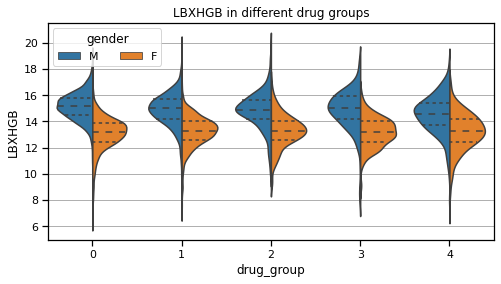

In [15]:
col = 'LBXHGB'

fig, ax = plt.subplots(figsize=(8,4))
ax.grid()
ax.set_axisbelow(True)
# ax.set_ylim(5,85)
ax.set_title(f'{col} in different drug groups')
ax.set_ylabel(col)
sns.violinplot(data=cbc, x='drug_group', y=col, hue='RIAGENDR', split=True, inner='quartile', ax=ax)
plt.legend(title='gender', handles=ax.get_legend().legendHandles, labels=('M','F'), ncol=2, loc='upper left')
plt.show()

In [17]:
# nrx = df[df.RXDDRGID == ''].groupby('SEQN').RXDDRGID.nunique()  #.value_counts()
# nrx.value_counts()

In [ ]:
# interesting people
# dfs['BMX'].query("SEQN == 100222")  ## 22 prescriptions
# dfs['BMX'].query("SEQN == 77111")  ## 23 prescriptions

# df[df.apply(lambda x: x.astype(str).str.contains('alg', case=False)).any(axis=1)]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=98f37550-cbaa-491c-a3ea-f393696dc041' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>